# Notebook Goals:

* Normalize death count data to town population (turn raw counts into deaths per 10k residents values)
* Pull out some ACS demographics data - correlation with death data?
* 

# Output:
* /data/tidy_data/

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set(font_scale=1.5)

In [2]:
death_data = pd.read_csv("../../data/tidy_data/ma_town_opioid_overdose_death_by_place_of_death_2012_to_2018_merge.csv")
town_block_match = pd.read_csv("../../data/tidy_data/census_block_town_match.csv")
acs_17 = pd.read_csv("../../data/raw_data/R12288202_SL150.csv")

In [3]:
death_data.head()

,city_death,2012,2013,2014,2015,2016,2017,2018
0,abington,1,2,0,6,1,3,5
1,acton,2,0,1,2,3,0,1
2,acushnet,2,0,0,4,2,4,0
3,adams,1,1,2,3,1,0,4
4,agawam,1,3,1,2,0,4,8


In [4]:
display(town_block_match.head())
# remove extra column
town_block_match.drop('Unnamed: 0', axis=1, inplace=True)

,Unnamed: 0,TOWN,POP2010,SHAPE_Area,GEOID10,SHAPE_AREA,POP100_RE
0,0,wellesley,27982,2.726958e+07,2.502140e+11,6.424854e+05,935.0
1,0,wellesley,27982,2.726958e+07,2.502140e+11,1.167837e+06,989.0
2,0,wellesley,27982,2.726958e+07,2.502140e+11,1.182595e+06,968.0
3,0,wellesley,27982,2.726958e+07,2.502140e+11,1.079832e+06,1145.0
4,0,wellesley,27982,2.726958e+07,2.502140e+11,5.306549e+05,664.0


In [5]:
# town mismatch between death count data and the town-census block 
print(set(death_data['city_death']) - set(town_block_match['TOWN']))
print(set(town_block_match['TOWN']) - set(death_data['city_death']))
death_data['city_death'] = death_data['city_death'].str.replace('north attleboro', 'north attleborough')

{'north attleboro'}
{'north attleborough'}


In [6]:
# grab relevant columns from match file
town_block = town_block_match[['TOWN', 'POP2010', 'SHAPE_Area', 'GEOID10']].copy()

In [7]:
print(acs_17.shape)
acs_17.columns

(4985, 2200)


Index(['Geo_FIPS', 'Geo_GEOID', 'Geo_NAME', 'Geo_QName', 'Geo_STUSAB',
       'Geo_SUMLEV', 'Geo_GEOCOMP', 'Geo_FILEID', 'Geo_LOGRECNO', 'Geo_US',
       ...
       'SE_A10065_001', 'SE_A10065_002', 'SE_A10066_001', 'SE_A10066_002',
       'SE_A10066_003', 'SE_A10066_004', 'SE_A10066_005', 'SE_A10066_006',
       'SE_A10066_007', 'SE_A10066_008'],
      dtype='object', length=2200)

In [8]:
# which columns to match on?
acs_17[['Geo_FIPS', 'Geo_GEOID']].head()
# Geo_FIPS is match for GEOID10 from town - block match df

,Geo_FIPS,Geo_GEOID
0,250010101001,15000US250010101001
1,250010101002,15000US250010101002
2,250010101003,15000US250010101003
3,250010101004,15000US250010101004
4,250010101005,15000US250010101005


In [9]:
# mismatches between sets?
print(len(set(acs_17['Geo_FIPS']) - set(town_block['GEOID10'])))
print(len(set(town_block['GEOID10']) - set(acs_17['Geo_FIPS'])))

31
4


### Potentially interesting columns to pull from ACS:
* A00002_001:   Total Population
* A00002_002:   Population Density (Per Sq. Mile)
* A12003_001:   Civilian Population 16 to 19 Years:
* A12003_002:      Not High School Graduate, Not Enrolled (Dropped Out)
* A12003_003:      High School Graduate, or Enrolled (In School)
* A12002_001:   Population 25 Years and Over:
* A12002_002:      Less than High School
* A14006_001:   Median Household Income (In 2017 Inflation Adjusted Dollars)
* A14008_001:   Average Household Income 
* NA- all missing - A14028_001:   Gini Index 
* NA - all missing - A17004_001:     Total Employed Civilian Population 16 Years and Over
* NA - all missing - A17004_002:     Employed Civilian Population 16 Years and Over: Agriculture, Forestry, Fishing and Hunting, and Mining
* NA - all missing - A17004_003:     Employed Civilian Population 16 Years and Over: Construction

In [10]:
acs_17_sub = acs_17[['Geo_FIPS', 'SE_A00002_001', 'SE_A00002_002',
     'SE_A12003_001', 'SE_A12003_002',
    'SE_A12002_001', 'SE_A12002_002', 'SE_A14006_001',
     'SE_A14008_001']].copy()

In [11]:
acs_17_sub.head()

,Geo_FIPS,SE_A00002_001,SE_A00002_002,SE_A12003_001,SE_A12003_002,SE_A12002_001,SE_A12002_002,SE_A14006_001,SE_A14008_001
0,250010101001,998,116.1545,8,0,894,46,52340.0,75538.664323
1,250010101002,314,613.6218,0,0,292,8,37841.0,65213.419913
2,250010101003,750,3997.7830,12,0,638,28,58098.0,84414.854111
3,250010101004,500,2019.0900,2,0,437,23,30396.0,46373.442623
4,250010101005,390,2952.7180,0,0,377,28,47895.0,66060.344828


In [12]:
# readable names:
acs_17_sub.columns = ['GEOID10', 'tot_pop', 'pop_density',
 'civ_pop_16_19', 'civ_pop_16_19_drop',
 'pop_over_25', 'pop_over_25_less_school', 'med_house_inc',
'mean_house_inc']

In [13]:
acs_17_sub.head()

,GEOID10,tot_pop,pop_density,civ_pop_16_19,civ_pop_16_19_drop,pop_over_25,pop_over_25_less_school,med_house_inc,mean_house_inc
0,250010101001,998,116.1545,8,0,894,46,52340.0,75538.664323
1,250010101002,314,613.6218,0,0,292,8,37841.0,65213.419913
2,250010101003,750,3997.7830,12,0,638,28,58098.0,84414.854111
3,250010101004,500,2019.0900,2,0,437,23,30396.0,46373.442623
4,250010101005,390,2952.7180,0,0,377,28,47895.0,66060.344828


In [14]:
acs_17_sub['drop_out'] = (acs_17_sub['civ_pop_16_19_drop'] * 100) / acs_17_sub['civ_pop_16_19']
acs_17_sub.drop(['civ_pop_16_19_drop', 'civ_pop_16_19'], axis = 1, inplace=True)
acs_17_sub.head()

,GEOID10,tot_pop,pop_density,pop_over_25,pop_over_25_less_school,med_house_inc,mean_house_inc,drop_out
0,250010101001,998,116.1545,894,46,52340.0,75538.664323,0.0
1,250010101002,314,613.6218,292,8,37841.0,65213.419913,NaN
2,250010101003,750,3997.7830,638,28,58098.0,84414.854111,0.0
3,250010101004,500,2019.0900,437,23,30396.0,46373.442623,0.0
4,250010101005,390,2952.7180,377,28,47895.0,66060.344828,NaN


In [15]:
acs_17_sub['less_than_hs_ed'] = (acs_17_sub['pop_over_25_less_school'] * 100) / acs_17_sub['pop_over_25']
acs_17_sub.drop(['pop_over_25', 'pop_over_25_less_school'], axis = 1, inplace=True)
acs_17_sub.head()

,GEOID10,tot_pop,pop_density,med_house_inc,mean_house_inc,drop_out,less_than_hs_ed
0,250010101001,998,116.1545,52340.0,75538.664323,0.0,5.145414
1,250010101002,314,613.6218,37841.0,65213.419913,NaN,2.739726
2,250010101003,750,3997.7830,58098.0,84414.854111,0.0,4.388715
3,250010101004,500,2019.0900,30396.0,46373.442623,0.0,5.263158
4,250010101005,390,2952.7180,47895.0,66060.344828,NaN,7.427056


In [16]:
acs_17_sub['mean_med_inc_desp'] = acs_17_sub['mean_house_inc'] - acs_17_sub['med_house_inc']
acs_17_sub.head()

,GEOID10,tot_pop,pop_density,med_house_inc,mean_house_inc,drop_out,less_than_hs_ed,mean_med_inc_desp
0,250010101001,998,116.1545,52340.0,75538.664323,0.0,5.145414,23198.664323
1,250010101002,314,613.6218,37841.0,65213.419913,NaN,2.739726,27372.419913
2,250010101003,750,3997.7830,58098.0,84414.854111,0.0,4.388715,26316.854111
3,250010101004,500,2019.0900,30396.0,46373.442623,0.0,5.263158,15977.442623
4,250010101005,390,2952.7180,47895.0,66060.344828,NaN,7.427056,18165.344828


In [17]:
acs_17_sub.describe()

,GEOID10,tot_pop,pop_density,med_house_inc,mean_house_inc,drop_out,less_than_hs_ed,mean_med_inc_desp
count,4.985000e+03,4985.000000,4978.000000,4754.000000,4945.000000,4522.000000,4966.000000,4754.000000
mean,2.501713e+11,1361.949649,8442.368002,82522.340766,101843.077887,3.243938,10.322376,20133.424207
std,7.723758e+07,670.479216,12666.048861,40805.023166,52403.666245,11.600150,10.883416,23260.818374
min,2.500101e+11,0.000000,0.000000,2499.000000,14219.285714,0.000000,0.000000,-28320.588235
25%,2.500927e+11,880.000000,1082.917000,53333.000000,66678.928571,0.000000,2.733292,7708.925394
50%,2.501735e+11,1220.000000,3632.338000,77321.000000,92363.461538,0.000000,6.583277,14932.428493
75%,2.502354e+11,1696.000000,10744.957500,104048.250000,123559.710145,0.000000,14.309627,25253.478921
max,2.502776e+11,6760.000000,183026.000000,250001.000000,526877.386935,100.000000,100.000000,276876.386935


In [18]:
# drop out column doesn't look like it will be very useful
acs_17_sub.drop('drop_out', axis=1, inplace=True)

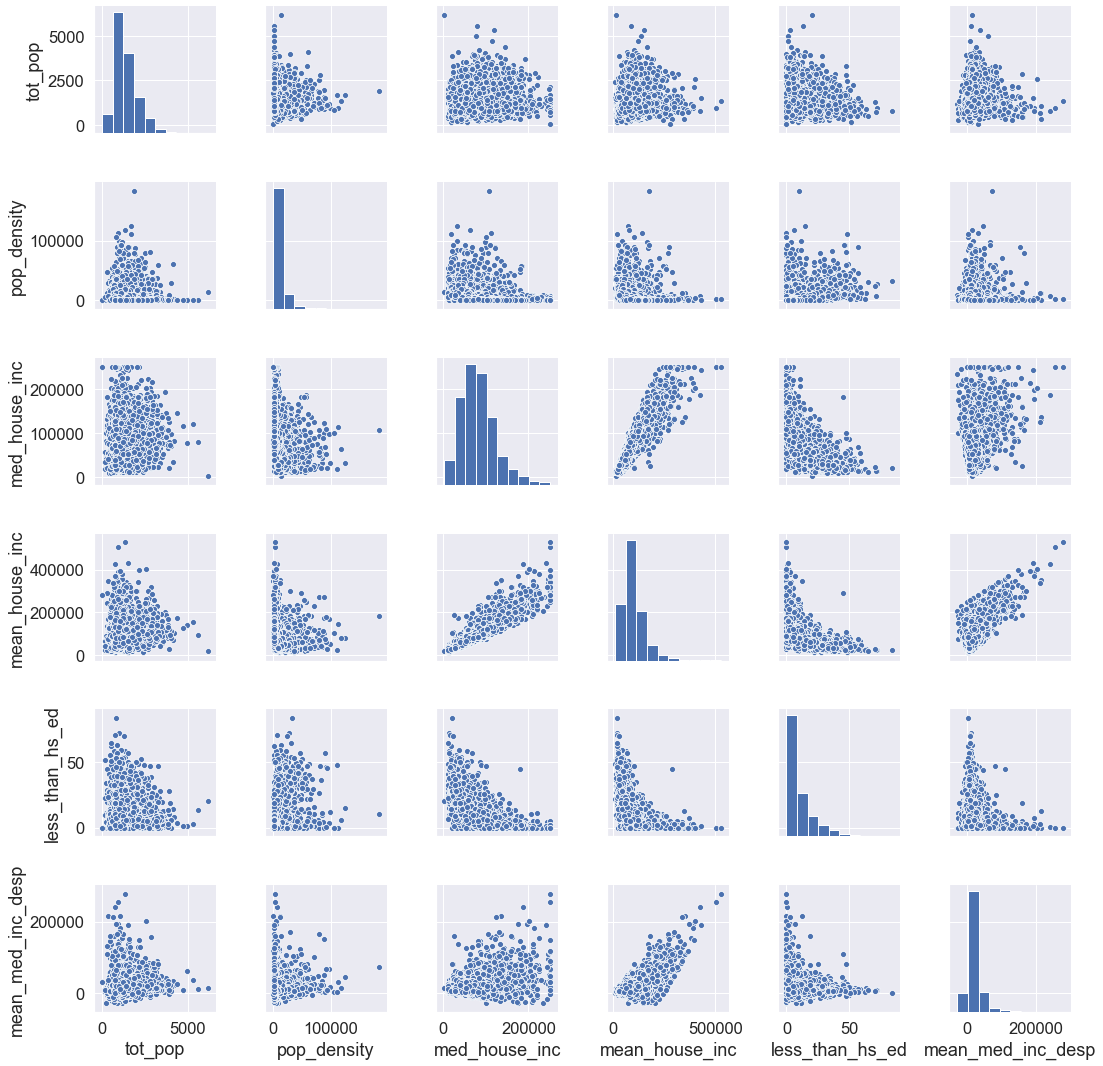

In [19]:
sns.pairplot(acs_17_sub.dropna().iloc[:, 1:])

In [20]:
print(acs_17_sub.columns)
print(town_block.columns)

Index(['GEOID10', 'tot_pop', 'pop_density', 'med_house_inc', 'mean_house_inc',
       'less_than_hs_ed', 'mean_med_inc_desp'],
      dtype='object')
Index(['TOWN', 'POP2010', 'SHAPE_Area', 'GEOID10'], dtype='object')


In [21]:
town_block.columns = ['city_death', 'tot_pop_10', 'shape_area', 'GEOID10']

In [22]:
town_block.head()

,city_death,tot_pop_10,shape_area,GEOID10
0,wellesley,27982,2.726958e+07,2.502140e+11
1,wellesley,27982,2.726958e+07,2.502140e+11
2,wellesley,27982,2.726958e+07,2.502140e+11
3,wellesley,27982,2.726958e+07,2.502140e+11
4,wellesley,27982,2.726958e+07,2.502140e+11


In [23]:
town_acs_merge = town_block.merge(acs_17_sub, on='GEOID10', how='inner')

In [24]:
town_acs_merge.columns

Index(['city_death', 'tot_pop_10', 'shape_area', 'GEOID10', 'tot_pop',
       'pop_density', 'med_house_inc', 'mean_house_inc', 'less_than_hs_ed',
       'mean_med_inc_desp'],
      dtype='object')

In [25]:
town_acs_merge.head()

,city_death,tot_pop_10,shape_area,GEOID10,tot_pop,pop_density,med_house_inc,mean_house_inc,less_than_hs_ed,mean_med_inc_desp
0,wellesley,27982,2.726958e+07,2.502140e+11,1101,4438.051,183879.0,214803.395062,0.000000,30924.395062
1,wellesley,27982,2.726958e+07,2.502140e+11,924,2064.697,250001.0,505804.304636,0.000000,255803.304636
2,wellesley,27982,2.726958e+07,2.502140e+11,881,1947.536,181786.0,244652.447552,1.992754,62866.447552
3,wellesley,27982,2.726958e+07,2.502140e+11,1177,2961.899,129071.0,240321.641791,4.379562,111250.641791
4,wellesley,27982,2.726958e+07,2.502140e+11,767,3843.039,86827.0,145115.151515,3.728814,58288.151515


In [26]:
town_17_pop = town_acs_merge.groupby('city_death').sum().reset_index()[['city_death', 'tot_pop']]
town_17_pop.columns = ['city_death', 'tot_pop_17']
town_17_pop.head()

,city_death,tot_pop_17
0,abington,16275
1,acton,23455
2,acushnet,10443
3,adams,8211
4,agawam,27769


In [27]:
# get mean of other stats:
town_stats = town_acs_merge.groupby('city_death').mean().reset_index().drop(['GEOID10', 'tot_pop'], axis=1)
town_stats.head()

,city_death,tot_pop_10,shape_area,pop_density,med_house_inc,mean_house_inc,less_than_hs_ed,mean_med_inc_desp
0,abington,15985.0,2.639085e+07,1932.969130,87156.000000,98809.035505,5.334519,11653.035505
1,acton,21924.0,5.256453e+07,1257.583593,139890.466667,156680.203867,2.778635,16789.737200
2,acushnet,10303.0,4.889337e+07,1152.357871,69624.714286,80333.175842,17.217211,10708.461556
3,adams,8485.0,5.946649e+07,1982.318840,48445.400000,60968.594660,12.015167,12523.194660
4,agawam,28438.0,6.302191e+07,1897.273569,65490.125000,79464.234446,7.943053,13974.109446


In [28]:
# combine town info + opioid overdose death count data
full_merge = town_17_pop.merge(town_stats, on='city_death', how='inner').merge(death_data, on='city_death', how='inner')
full_merge.head()

,city_death,tot_pop_17,tot_pop_10,shape_area,pop_density,med_house_inc,mean_house_inc,less_than_hs_ed,mean_med_inc_desp,2012,2013,2014,2015,2016,2017,2018
0,abington,16275,15985.0,2.639085e+07,1932.969130,87156.000000,98809.035505,5.334519,11653.035505,1,2,0,6,1,3,5
1,acton,23455,21924.0,5.256453e+07,1257.583593,139890.466667,156680.203867,2.778635,16789.737200,2,0,1,2,3,0,1
2,acushnet,10443,10303.0,4.889337e+07,1152.357871,69624.714286,80333.175842,17.217211,10708.461556,2,0,0,4,2,4,0
3,adams,8211,8485.0,5.946649e+07,1982.318840,48445.400000,60968.594660,12.015167,12523.194660,1,1,2,3,1,0,4
4,agawam,27769,28438.0,6.302191e+07,1897.273569,65490.125000,79464.234446,7.943053,13974.109446,1,3,1,2,0,4,8


In [29]:
full_merge['area'] = full_merge['tot_pop_17'] / full_merge['pop_density']

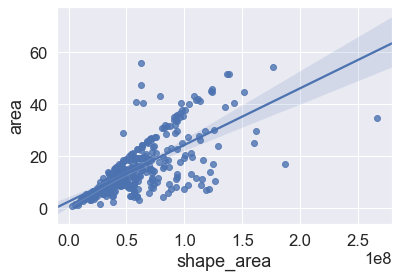

In [30]:
sns.regplot(x='shape_area', y='area', data=full_merge)

In [31]:
full_merge.drop('area', axis=1, inplace=True)

In [32]:
full_merge.head()

,city_death,tot_pop_17,tot_pop_10,shape_area,pop_density,med_house_inc,mean_house_inc,less_than_hs_ed,mean_med_inc_desp,2012,2013,2014,2015,2016,2017,2018
0,abington,16275,15985.0,2.639085e+07,1932.969130,87156.000000,98809.035505,5.334519,11653.035505,1,2,0,6,1,3,5
1,acton,23455,21924.0,5.256453e+07,1257.583593,139890.466667,156680.203867,2.778635,16789.737200,2,0,1,2,3,0,1
2,acushnet,10443,10303.0,4.889337e+07,1152.357871,69624.714286,80333.175842,17.217211,10708.461556,2,0,0,4,2,4,0
3,adams,8211,8485.0,5.946649e+07,1982.318840,48445.400000,60968.594660,12.015167,12523.194660,1,1,2,3,1,0,4
4,agawam,27769,28438.0,6.302191e+07,1897.273569,65490.125000,79464.234446,7.943053,13974.109446,1,3,1,2,0,4,8


In [33]:
full_merge['pop_change_rate'] = (full_merge['tot_pop_17'] - full_merge['tot_pop_10']) / (2017 - 2010)
full_merge['tot_pop_16'] = full_merge['tot_pop_17'] - full_merge['pop_change_rate']
full_merge['tot_pop_15'] = full_merge['tot_pop_17'] - full_merge['pop_change_rate'] * 2
full_merge['tot_pop_14'] = full_merge['tot_pop_17'] - full_merge['pop_change_rate'] * 3
full_merge['tot_pop_13'] = full_merge['tot_pop_17'] - full_merge['pop_change_rate'] * 4
full_merge['tot_pop_12'] = full_merge['tot_pop_17'] - full_merge['pop_change_rate'] * 5
full_merge['tot_pop_18'] = full_merge['tot_pop_17'] + full_merge['pop_change_rate']
full_merge.head()

,city_death,tot_pop_17,tot_pop_10,shape_area,pop_density,med_house_inc,mean_house_inc,less_than_hs_ed,mean_med_inc_desp,2012,...,2016,2017,2018,pop_change_rate,tot_pop_16,tot_pop_15,tot_pop_14,tot_pop_13,tot_pop_12,tot_pop_18
0,abington,16275,15985.0,2.639085e+07,1932.969130,87156.000000,98809.035505,5.334519,11653.035505,1,...,1,3,5,41.428571,16233.571429,16192.142857,16150.714286,16109.285714,16067.857143,16316.428571
1,acton,23455,21924.0,5.256453e+07,1257.583593,139890.466667,156680.203867,2.778635,16789.737200,2,...,3,0,1,218.714286,23236.285714,23017.571429,22798.857143,22580.142857,22361.428571,23673.714286
2,acushnet,10443,10303.0,4.889337e+07,1152.357871,69624.714286,80333.175842,17.217211,10708.461556,2,...,2,4,0,20.000000,10423.000000,10403.000000,10383.000000,10363.000000,10343.000000,10463.000000
3,adams,8211,8485.0,5.946649e+07,1982.318840,48445.400000,60968.594660,12.015167,12523.194660,1,...,1,0,4,-39.142857,8250.142857,8289.285714,8328.428571,8367.571429,8406.714286,8171.857143
4,agawam,27769,28438.0,6.302191e+07,1897.273569,65490.125000,79464.234446,7.943053,13974.109446,1,...,0,4,8,-95.571429,27864.571429,27960.142857,28055.714286,28151.285714,28246.857143,27673.428571


In [34]:
full_merge['death_rate_12'] = (full_merge['2012'] / full_merge['tot_pop_12']) * 10000
full_merge['death_rate_13'] = (full_merge['2013'] / full_merge['tot_pop_13']) * 10000
full_merge['death_rate_14'] = (full_merge['2014'] / full_merge['tot_pop_14']) * 10000
full_merge['death_rate_15'] = (full_merge['2015'] / full_merge['tot_pop_15']) * 10000
full_merge['death_rate_16'] = (full_merge['2016'] / full_merge['tot_pop_16']) * 10000
full_merge['death_rate_17'] = (full_merge['2017'] / full_merge['tot_pop_17']) * 10000
full_merge['death_rate_18'] = (full_merge['2018'] / full_merge['tot_pop_18']) * 10000

In [35]:
full_merge.head()

,city_death,tot_pop_17,tot_pop_10,shape_area,pop_density,med_house_inc,mean_house_inc,less_than_hs_ed,mean_med_inc_desp,2012,...,tot_pop_13,tot_pop_12,tot_pop_18,death_rate_12,death_rate_13,death_rate_14,death_rate_15,death_rate_16,death_rate_17,death_rate_18
0,abington,16275,15985.0,2.639085e+07,1932.969130,87156.000000,98809.035505,5.334519,11653.035505,1,...,16109.285714,16067.857143,16316.428571,0.622361,1.241520,0.000000,3.705501,0.616007,1.843318,3.064396
1,acton,23455,21924.0,5.256453e+07,1257.583593,139890.466667,156680.203867,2.778635,16789.737200,2,...,22580.142857,22361.428571,23673.714286,0.894397,0.000000,0.438618,0.868901,1.291084,0.000000,0.422409
2,acushnet,10443,10303.0,4.889337e+07,1152.357871,69624.714286,80333.175842,17.217211,10708.461556,2,...,10363.000000,10343.000000,10463.000000,1.933675,0.000000,0.000000,3.845045,1.918833,3.830317,0.000000
3,adams,8211,8485.0,5.946649e+07,1982.318840,48445.400000,60968.594660,12.015167,12523.194660,1,...,8367.571429,8406.714286,8171.857143,1.189525,1.195090,2.401413,3.619130,1.212100,0.000000,4.894848
4,agawam,27769,28438.0,6.302191e+07,1897.273569,65490.125000,79464.234446,7.943053,13974.109446,1,...,28151.285714,28246.857143,27673.428571,0.354022,1.065671,0.356434,0.715304,0.000000,1.440455,2.890860


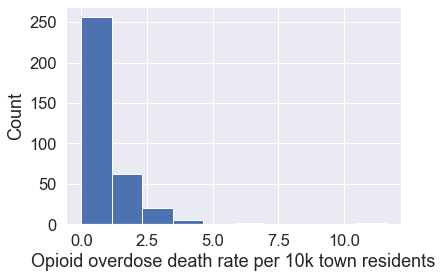

In [36]:
full_merge['death_rate_12'].hist()
plt.xlabel('Opioid overdose death rate per 10k town residents')
plt.ylabel('Count')
plt.show()

In [37]:
full_merge.columns

Index(['city_death', 'tot_pop_17', 'tot_pop_10', 'shape_area', 'pop_density',
       'med_house_inc', 'mean_house_inc', 'less_than_hs_ed',
       'mean_med_inc_desp', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018', 'pop_change_rate', 'tot_pop_16', 'tot_pop_15', 'tot_pop_14',
       'tot_pop_13', 'tot_pop_12', 'tot_pop_18', 'death_rate_12',
       'death_rate_13', 'death_rate_14', 'death_rate_15', 'death_rate_16',
       'death_rate_17', 'death_rate_18'],
      dtype='object')

In [41]:
full_merge_17 = full_merge.iloc[:, np.r_[0:2, 4:9, 14:16, 28:30]].copy()
full_merge_17.head()

,city_death,tot_pop_17,pop_density,med_house_inc,mean_house_inc,less_than_hs_ed,mean_med_inc_desp,2017,2018,death_rate_17,death_rate_18
0,abington,16275,1932.969130,87156.000000,98809.035505,5.334519,11653.035505,3,5,1.843318,3.064396
1,acton,23455,1257.583593,139890.466667,156680.203867,2.778635,16789.737200,0,1,0.000000,0.422409
2,acushnet,10443,1152.357871,69624.714286,80333.175842,17.217211,10708.461556,4,0,3.830317,0.000000
3,adams,8211,1982.318840,48445.400000,60968.594660,12.015167,12523.194660,0,4,0.000000,4.894848
4,agawam,27769,1897.273569,65490.125000,79464.234446,7.943053,13974.109446,4,8,1.440455,2.890860


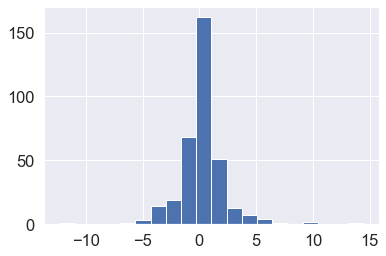

In [46]:
full_merge_17['rate_chng_17_to_18'] = full_merge_17['death_rate_18'] - full_merge_17['death_rate_17']
full_merge_17['rate_chng_17_to_18'].hist(bins=20)
plt.show()

In [50]:
full_merge_17.iloc[:, np.r_[11, 2:7]].describe()

,rate_chng_17_to_18,pop_density,med_house_inc,mean_house_inc,less_than_hs_ed,mean_med_inc_desp
count,347.000000,347.000000,346.000000,347.000000,347.000000,346.000000
mean,0.139812,2292.685930,88305.727278,109444.035932,6.601018,21079.291563
std,2.109397,4049.633320,29088.836206,39888.981321,4.846356,15309.458177
min,-12.330456,2.578370,38909.750000,50750.537570,0.000000,2129.112803
25%,-0.618454,285.202885,68215.428571,82839.316239,3.252697,12204.613762
50%,0.000000,933.183133,83124.625000,100209.367399,5.502973,16659.458813
75%,0.848789,2452.889962,102446.289216,126078.167762,8.473558,24196.761231
max,14.453851,30236.970333,203026.750000,316351.858774,32.730126,113325.108774


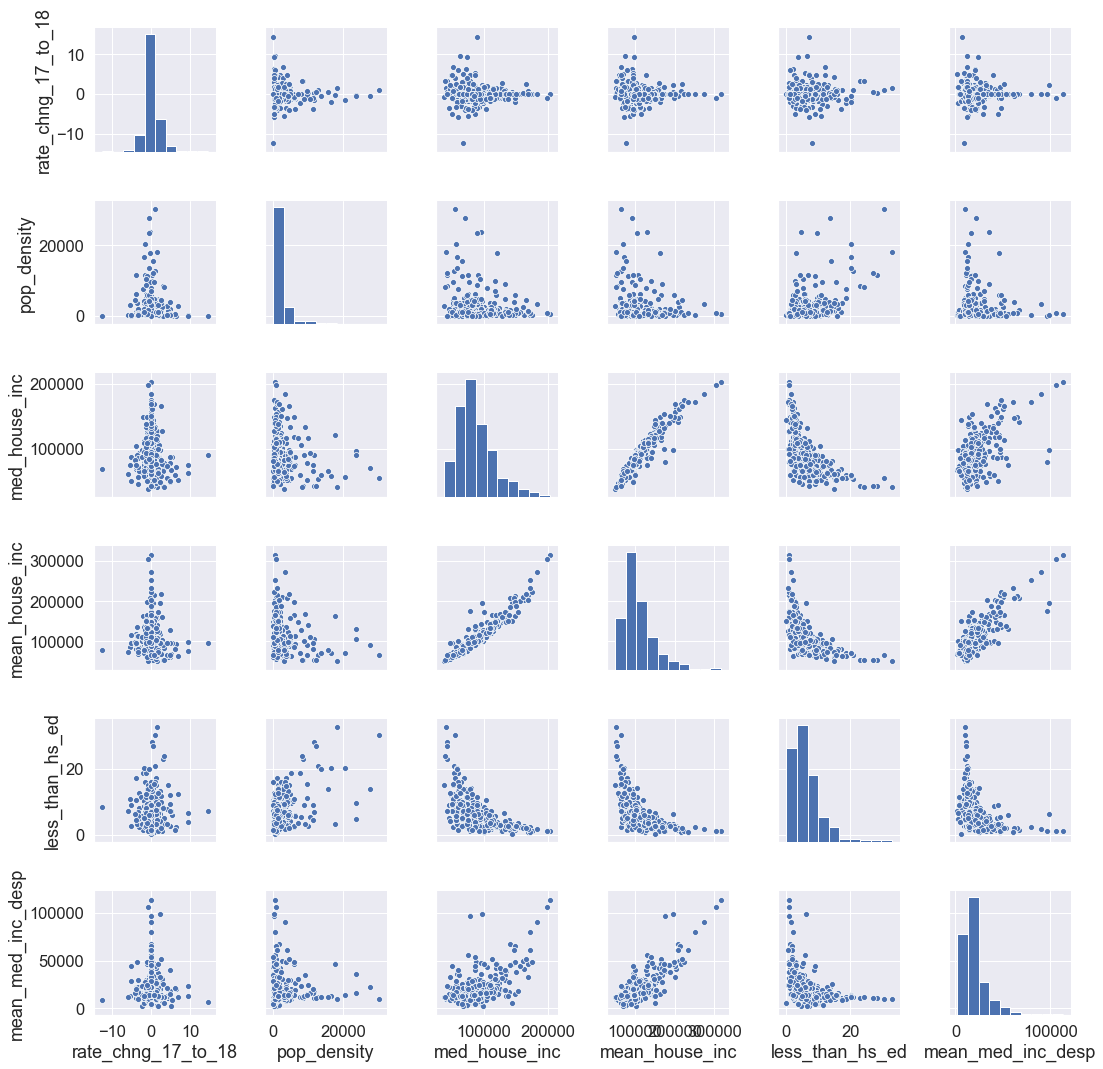

In [51]:
sns.pairplot(full_merge_17.iloc[:, np.r_[11, 2:7]].dropna())
plt.show()

In [56]:
urb_test = full_merge_17.iloc[:, np.r_[0:2, 11, 2:7]].copy()
urb_test['urb_v_rur'] = ['urban' if x >= 50000 else 'rural' for x in urb_test['tot_pop_17']]
urb_test['urb_v_rur'].value_counts()

rural    322
urban     25
Name: urb_v_rur, dtype: int64

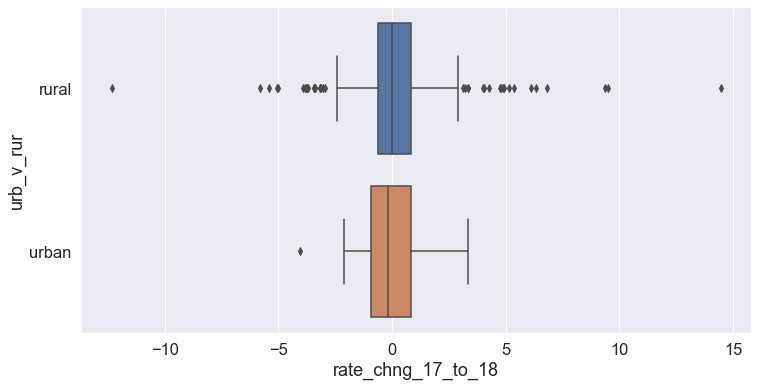

In [61]:
plt.figure(figsize=(12, 6))
sns.boxplot(y='urb_v_rur', x='rate_chng_17_to_18', orient='h', data=urb_test)
plt.show()

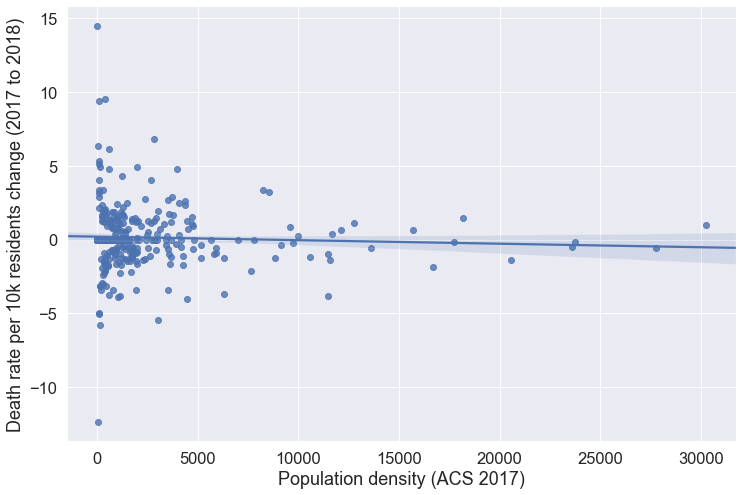

In [70]:
plt.figure(figsize=(12, 8))
sns.regplot(x='pop_density', y='rate_chng_17_to_18', data=full_merge_17)
plt.xlabel('Population density (ACS 2017)')
plt.ylabel('Death rate per 10k residents change (2017 to 2018)')
plt.show()

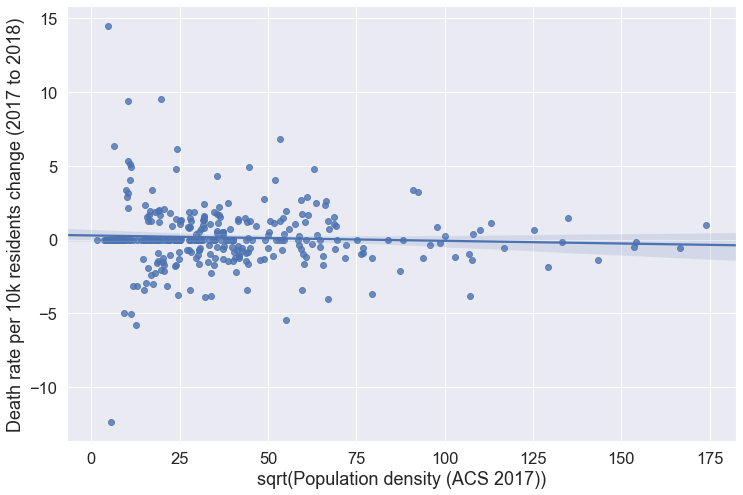

In [73]:
full_merge_17['pop_den_sqrt'] = np.sqrt(full_merge_17['pop_density'])
plt.figure(figsize=(12, 8))
sns.regplot(x='pop_den_sqrt', y='rate_chng_17_to_18', data=full_merge_17)
plt.xlabel('sqrt(Population density (ACS 2017))')
plt.ylabel('Death rate per 10k residents change (2017 to 2018)')
plt.show()

In [74]:
full_merge.columns

Index(['city_death', 'tot_pop_17', 'tot_pop_10', 'shape_area', 'pop_density',
       'med_house_inc', 'mean_house_inc', 'less_than_hs_ed',
       'mean_med_inc_desp', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018', 'pop_change_rate', 'tot_pop_16', 'tot_pop_15', 'tot_pop_14',
       'tot_pop_13', 'tot_pop_12', 'tot_pop_18', 'death_rate_12',
       'death_rate_13', 'death_rate_14', 'death_rate_15', 'death_rate_16',
       'death_rate_17', 'death_rate_18'],
      dtype='object')

In [80]:
full_merge_cols = list(full_merge.columns)
full_merge_cols[:1] + full_merge_cols[3:4] + full_merge_cols[22:23] + full_merge_cols[1:2] + full_merge_cols[17:22] + full_merge_cols[9:16]

['city_death',
 'shape_area',
 'tot_pop_18',
 'tot_pop_17',
 'tot_pop_16',
 'tot_pop_15',
 'tot_pop_14',
 'tot_pop_13',
 'tot_pop_12',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018']